In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 

import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --------------------------
# Sparse Recurrent Connections
# --------------------------
class SparseConstraint(tf.keras.constraints.Constraint):
    def __init__(self, prob_connection, units):
        """
        Constructs a fixed binary mask for recurrent weights.
        Args:
            prob_connection (float): Desired connection probability.
            units (int): Number of GRU units.
        """
        self.prob_connection = prob_connection
        self.units = units

        # Create a base mask of shape (units, units)
        base_mask = np.random.rand(units, units) < prob_connection
        self.base_mask = tf.constant(base_mask.astype(np.float32))
    
    def __call__(self, w):
        # w is expected to have shape (units, m) where m is a multiple of units.
        m = w.shape[1]
        factor = m // self.units
        # Tiled mask of shape (units, units x factor)
        mask_tiled = tf.tile(self.base_mask, [1, factor])
        return w * mask_tiled
    
    def get_config(self):
        return {'prob_connection': self.prob_connection, 'units': self.units}

# --------------------------
# Modified GRU unit
# --------------------------
class ModifiedGRUCell(tf.keras.layers.Layer):
    def __init__(self, units, alpha=0.1, **kwargs):
        """
        A modified GRU cell that implements leaky, threshold-linear dynamics with dynamic time constants.
        Args:
            units (int): Number of units.
            alpha (float): A factor representing the discretized time step over the time constant.
        """
        super(ModifiedGRUCell, self).__init__(**kwargs)
        self.units = units
        self.alpha = alpha
        self.state_size = units
        self.output_size = units

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Weights for the direct input and recurrent candidate term
        self.W_in = self.add_weight(shape=(input_dim, self.units),
                                    initializer='glorot_uniform',
                                    name='W_in')
        self.W_rec = self.add_weight(shape=(self.units, self.units),
                                     initializer='orthogonal',
                                     name='W_rec')
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 name='b')
        
        # Weights for the gate l
        self.Wl_in = self.add_weight(shape=(input_dim, self.units),
                                     initializer='glorot_uniform',
                                     name='Wl_in')
        self.Wl_rec = self.add_weight(shape=(self.units, self.units),
                                      initializer='orthogonal',
                                      name='Wl_rec')
        self.bl = self.add_weight(shape=(self.units,),
                                  initializer='zeros',
                                  name='bl')
        
        # Weights for the gate g
        self.Wg_in = self.add_weight(shape=(input_dim, self.units),
                                     initializer='glorot_uniform',
                                     name='Wg_in')
        self.Wg_rec = self.add_weight(shape=(self.units, self.units),
                                      initializer='orthogonal',
                                      name='Wg_rec')
        self.bg = self.add_weight(shape=(self.units,),
                                  initializer='zeros',
                                  name='bg')
        super(ModifiedGRUCell, self).build(input_shape)

    def call(self, inputs, states):
        h_prev = states[0]

        # Compute the leak gate l that modulates the effective time constant
        l = tf.sigmoid(tf.matmul(h_prev, self.Wl_rec) + tf.matmul(inputs, self.Wl_in) + self.bl)

        # Compute the gate g that modulates the recurrent input
        g = tf.sigmoid(tf.matmul(h_prev, self.Wg_rec) + tf.matmul(inputs, self.Wg_in) + self.bg)

        # Compute the candidate update
        candidate = tf.matmul(g * h_prev, self.W_rec) + tf.matmul(inputs, self.W_in) + self.b

        # Update the state
        h_new = h_prev + self.alpha * l * (-h_prev + candidate)

        # Apply threshold-linear activation
        h_new = tf.maximum(0.0, h_new)

        return h_new, [h_new]

class ModifiedGRU(tf.keras.layers.Layer):
    def __init__(self, units, return_sequences=False, return_state=False, alpha=0.1, **kwargs):
        """
        Wrapper for the ModifiedGRUCell to mimic the API of tf.keras.layers.GRU.
        Args:
            units (int): Number of units.
            return_sequences (bool): Whether to return the full sequence or only the last output.
            return_state (bool): Whether to return the last state.
            alpha (float): Time-step over time constant factor.
        """
        super(ModifiedGRU, self).__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.alpha = alpha
        self.cell = ModifiedGRUCell(units, alpha=alpha)

    def call(self, inputs, initial_state=None, training=None):

        # Use tf.keras.layers.RNN wrapper with the custom cell.
        rnn_layer = tf.keras.layers.RNN(self.cell,
                                        return_sequences=self.return_sequences,
                                        return_state=self.return_state)
        return rnn_layer(inputs, initial_state=initial_state, training=training)

# --------------------------
# Helper function: Metrics plot
# --------------------------
def plot_metrics(total_rewards, actor_losses, critic_losses, window_1=10, window_2=25):
    """
    Plots the raw metrics and their rolling statistics over windows of window_1 and window_2 episodes.
    Each column corresponds to one metric:
      - Column 1: Total Reward
      - Column 2: Actor Loss
      - Column 3: Critic Loss
    Row 1: Raw metrics.
    Row 2: Rolling mean, median, and std over a window of window_1 episodes.
    Row 3: Rolling mean, median, and std over a window of window_2 episodes.
    """
    def plot_rolling(ax, data, window, label):
        series = pd.Series(data)
        rolling_mean = series.rolling(window=window, min_periods=1).mean()
        rolling_median = series.rolling(window=window, min_periods=1).median()
        rolling_std = series.rolling(window=window, min_periods=1).std()
        ax.plot(episodes, rolling_mean, label="Mean")
        ax.plot(episodes, rolling_median, label="Median")
        ax.fill_between(episodes, rolling_mean - rolling_std, rolling_mean + rolling_std,
                        alpha=0.2, label="Std")
        ax.set_title(f"Rolling (window={window}) {label}")
        ax.set_xlabel("Episode")
        ax.legend()

    episodes = range(1, len(total_rewards) + 1)
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    
    axs[0, 0].plot(episodes, total_rewards, label="Raw")
    axs[0, 0].set_title("Raw Total Reward")
    axs[0, 0].set_xlabel("Episode")
    axs[0, 0].set_ylabel("Total Reward")
    axs[0, 0].legend()
    
    axs[0, 1].plot(episodes, actor_losses, label="Raw", color="tab:orange")
    axs[0, 1].set_title("Raw Actor Loss")
    axs[0, 1].set_xlabel("Episode")
    axs[0, 1].set_ylabel("Actor Loss")
    axs[0, 1].legend()
    
    axs[0, 2].plot(episodes, critic_losses, label="Raw", color="tab:green")
    axs[0, 2].set_title("Raw Critic Loss")
    axs[0, 2].set_xlabel("Episode")
    axs[0, 2].set_ylabel("Critic Loss")
    axs[0, 2].legend()
    
    plot_rolling(axs[1, 0], total_rewards, window_1, "Total Reward")
    plot_rolling(axs[1, 1], actor_losses, window_1, "Actor Loss")
    plot_rolling(axs[1, 2], critic_losses, window_1, "Critic Loss")
    
    plot_rolling(axs[2, 0], total_rewards, window_2, "Total Reward")
    plot_rolling(axs[2, 1], actor_losses, window_2, "Actor Loss")
    plot_rolling(axs[2, 2], critic_losses, window_2, "Critic Loss")
    
    plt.tight_layout()
    plt.show()

# --------------------------
# Helper function: Discount reward
# --------------------------
def discount_rewards(rewards, gamma):
    """
    Computes discounted rewards.
    Args:
        rewards (list): List of rewards collected in an episode.
        gamma (float): Discount factor.
    Returns:
        np.array: Discounted rewards.
    """
    discounted = np.zeros_like(rewards, dtype=np.float32)
    cumulative = 0.0
    for i in reversed(range(len(rewards))):
        cumulative = rewards[i] + gamma * cumulative
        discounted[i] = cumulative
    return discounted

# --------------------------
# Actor (Policy) Network
# --------------------------
class ActorModel(Model):
    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size,
                 num_layers=1,
                 prob_connection=0.1,
                 gru_type='standard'):
        """
        Actor network that uses GRU layers to output action probabilities.
        Args:
            input_size (int): Dimensionality of the observations (states).
            hidden_size (int): Number of GRU units.
            output_size (int): Number of actions.
            num_layers (int): Number of GRU layers.
            prob_connection (float): Connection probability for recurrent weights.
            gru_type (str): 'standard' to use standard GRU units, 'modified' to use modified GRU units.
        """
        super(ActorModel, self).__init__()
        self.num_layers = num_layers
        self.gru_layers = []
        for i in range(num_layers):
            recurrent_constraint = None
            if prob_connection < 1.0:
                recurrent_constraint = SparseConstraint(prob_connection, hidden_size)
            if gru_type == 'modified':
                self.gru_layers.append(ModifiedGRU(hidden_size,
                                                   return_sequences=True,
                                                   return_state=True))
            else:
                self.gru_layers.append(layers.GRU(hidden_size,
                                                  activation=tf.nn.tanh,
                                                  recurrent_activation=tf.nn.sigmoid,
                                                  return_sequences=True,
                                                  return_state=True,
                                                  recurrent_constraint=recurrent_constraint))
        self.fc = layers.Dense(output_size)

    def call(self, inputs, hidden_states=None, training=None):
        output = inputs
        new_states = []
        for i, gru in enumerate(self.gru_layers):
            current_state = hidden_states[i] if hidden_states is not None else None
            output, state = gru(output, initial_state=current_state, training=training)
            new_states.append(state)
        logits = self.fc(output[:, -1, :])
        probs = tf.nn.softmax(logits, axis=-1)
        return probs, new_states

# --------------------------
# Critic (Value) Network
# --------------------------
class CriticModel(Model):
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers=1,
                 prob_connection=1.0,
                 gru_type='standard'):
        """
        Critic network that uses GRU layers to output a scalar value estimate.
        Args:
            input_size (int): Dimensionality of the observations.
            hidden_size (int): Number of GRU units.
            num_layers (int): Number of GRU layers.
            prob_connection (float): Connection probability for recurrent weights.
            gru_type (str): 'standard' to use standard GRU units, 'modified' to use modified GRU units.
        """
        super(CriticModel, self).__init__()
        self.num_layers = num_layers
        self.gru_layers = []
        for i in range(num_layers):
            recurrent_constraint = None
            if prob_connection < 1.0:
                recurrent_constraint = SparseConstraint(prob_connection, hidden_size)
            if gru_type == 'modified':
                self.gru_layers.append(ModifiedGRU(hidden_size,
                                                   return_sequences=True,
                                                   return_state=True))
            else:
                self.gru_layers.append(layers.GRU(hidden_size,
                                                  activation=tf.nn.tanh,
                                                  recurrent_activation=tf.nn.sigmoid,
                                                  return_sequences=True,
                                                  return_state=True,
                                                  recurrent_constraint=recurrent_constraint))
        self.fc = layers.Dense(1)

    def call(self, inputs, hidden_states=None, training=None):
        output = inputs
        new_states = []
        for i, gru in enumerate(self.gru_layers):
            current_state = hidden_states[i] if hidden_states is not None else None
            output, state = gru(output, initial_state=current_state, training=training)
            new_states.append(state)
        value = self.fc(output[:, -1, :])
        return value, new_states

# --------------------------
# Actor-Critic Agent
# --------------------------
class ActorCriticAgent:
    def __init__(self,
                 obs_size,
                 act_size,
                 actor_hidden_size=128,
                 critic_hidden_size=128,
                 actor_layers=1,
                 critic_layers=1,
                 actor_lr=1e-3,
                 critic_lr=1e-3,
                 noise_std=0.0,
                 actor_prob_connection=0.1,
                 critic_prob_connection=1.0,
                 gru_type='standard'):
        """
        Container for the actor and critic networks and their optimizers.
        Args:
            obs_size (int): Dimension of observations.
            act_size (int): Number of actions.
            actor_hidden_size (int): Number of hidden units in the actor GRU.
            critic_hidden_size (int): Number of hidden units in the critic GRU.
            actor_layers (int): Number of GRU layers in the actor.
            critic_layers (int): Number of GRU layers in the critic.
            actor_lr (float): Learning rate for the actor.
            critic_lr (float): Learning rate for the critic.
            noise_std (float): Standard deviation of Gaussian noise added to the input state.
            actor_prob_connection (float): Connection probability for actor's recurrent weights.
            critic_prob_connection (float): Connection probability for critic's recurrent weights.
            gru_type (str): 'standard' to use standard GRU units, 'modified' to use modified GRU units.
        """
        self.actor = ActorModel(
            input_size=obs_size,
            hidden_size=actor_hidden_size,
            output_size=act_size,
            num_layers=actor_layers,
            prob_connection=actor_prob_connection,
            gru_type=gru_type
        )
        self.critic = CriticModel(
            input_size=obs_size,
            hidden_size=critic_hidden_size,
            num_layers=critic_layers,
            prob_connection=critic_prob_connection,
            gru_type=gru_type
        )
        self.actor_optimizer = optimizers.Adam(learning_rate=actor_lr)
        self.critic_optimizer = optimizers.Adam(learning_rate=critic_lr)
        self.noise_std = noise_std

    def add_noise(self, state):
        """
        Adds Gaussian noise to the state if noise_std is non-zero.
        Args:
            state (np.array): Original state.
        Returns:
            np.array: Noisy state.
        """
        if self.noise_std != 0.0:
            return state + np.random.normal(0, self.noise_std, size=state.shape)
        return state

    def select_action(self, state, actor_hidden_states=None, training=True):
        """
        Selects an action based on the actor network.
        Args:
            state (np.array): Current observation (1D array).
            actor_hidden_states: Hidden states for the actor GRU (optional).
            training (bool): Flag indicating training mode.
        Returns:
            action (int): Selected action.
            log_prob (tf.Tensor): Log probability of the selected action.
            new_actor_hidden_states: Updated hidden states for the actor.
        """
        state = self.add_noise(state)
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, axis=0)
        state_tensor = tf.expand_dims(state_tensor, axis=1)
        probs, new_actor_hidden_states = self.actor(state_tensor, hidden_states=actor_hidden_states, training=training)
        action = tf.random.categorical(tf.math.log(probs), num_samples=1)
        action = tf.squeeze(action, axis=-1)
        action_one_hot = tf.one_hot(action, depth=probs.shape[-1])
        log_prob = tf.math.log(tf.reduce_sum(probs * action_one_hot, axis=-1))
        return int(action[0].numpy()), log_prob, new_actor_hidden_states

    def evaluate_state(self, state, critic_hidden_states=None, training=True):
        """
        Evaluates the state value using the critic network.
        Args:
            state (np.array): Current observation.
            critic_hidden_states: Hidden state(s) for the critic GRU (optional).
            training (bool): Flag indicating training mode.
        Returns:
            value (tf.Tensor): Estimated state value.
            new_critic_hidden_states: Updated hidden state(s) for the critic.
        """
        state = self.add_noise(state)
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, axis=0)
        state_tensor = tf.expand_dims(state_tensor, axis=1)
        value, new_critic_hidden_states = self.critic(state_tensor, hidden_states=critic_hidden_states, training=training)
        return value[0, 0], new_critic_hidden_states

# --------------------------
# Training using REINFORCE with baseline and regularization
# --------------------------
def train_agent(env, agent, num_episodes=500, gamma=0.99, print_interval=10, l2_actor=1e-4, l2_critic=1e-4):
    """
    For each episode:
      1. Run the policy to collect (state, action, reward) tuples.
      2. Compute discounted returns.
      3. Re-run the forward passes for both actor and critic inside gradient tapes.
      4. Update actor using:
            L_actor = - E[ log(pi(a|s)) * (R - V(s)) ] + L2 regularization term
         and critic using:
            L_critic = E[ (R - V(s))^2 ] + L2 regularization term
    """
    total_rewards_history = []
    actor_loss_history = []
    critic_loss_history = []

    lambda_actor = l2_actor
    lambda_critic = l2_critic

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        done = False
        states = []
        actions = []
        rewards = []

        while not done:
            action, _, _ = agent.select_action(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state

        returns = discount_rewards(rewards, gamma)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)

        with tf.GradientTape() as tape_actor:
            log_probs = []
            for s, a in zip(states, actions):
                s_noisy = agent.add_noise(s)
                s_tensor = tf.convert_to_tensor(s_noisy, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)
                probs, _ = agent.actor(s_tensor, hidden_states=None, training=True)
                a_one_hot = tf.one_hot(a, depth=probs.shape[-1])
                log_prob = tf.math.log(tf.reduce_sum(probs * a_one_hot, axis=-1) + 1e-8)
                log_probs.append(log_prob)
            log_probs = tf.stack(log_probs)

            values = []
            for s in states:
                s_noisy = agent.add_noise(s)
                s_tensor = tf.convert_to_tensor(s_noisy, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)
                value, _ = agent.critic(s_tensor, hidden_states=None, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)
            advantage = returns - values
            actor_loss = -tf.reduce_mean(log_probs * tf.stop_gradient(advantage))
            l2_reg_actor = tf.add_n([tf.nn.l2_loss(v) for v in agent.actor.trainable_variables])
            actor_loss += lambda_actor * l2_reg_actor

        actor_grads = tape_actor.gradient(actor_loss, agent.actor.trainable_variables)
        agent.actor_optimizer.apply_gradients(zip(actor_grads, agent.actor.trainable_variables))

        with tf.GradientTape() as tape_critic:
            values = []
            for s in states:
                s_noisy = agent.add_noise(s)
                s_tensor = tf.convert_to_tensor(s_noisy, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)
                value, _ = agent.critic(s_tensor, hidden_states=None, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)
            critic_loss = tf.reduce_mean(tf.square(returns - values))
            l2_reg_critic = tf.add_n([tf.nn.l2_loss(v) for v in agent.critic.trainable_variables])
            critic_loss += lambda_critic * l2_reg_critic

        critic_grads = tape_critic.gradient(critic_loss, agent.critic.trainable_variables)
        agent.critic_optimizer.apply_gradients(zip(critic_grads, agent.critic.trainable_variables))

        if episode % print_interval == 0:
            total_reward = sum(rewards)
            print(f"Episode {episode}\tTotal Reward: {total_reward:.2f}\t"
                  f"Actor Loss: {actor_loss.numpy():.4f}\tCritic Loss: {critic_loss.numpy():.4f}")

        total_reward = sum(rewards)
        total_rewards_history.append(total_reward)
        actor_loss_history.append(actor_loss.numpy())
        critic_loss_history.append(critic_loss.numpy())

    return total_rewards_history, actor_loss_history, critic_loss_history


2025-03-29 11:17:30.825217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743243450.883286  327811 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743243450.903230  327811 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-29 11:17:30.962211: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-03-28 16:28:09.066104: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Episode 10	Total Reward: 29.00	Actor Loss: 6.8379	Critic Loss: 114.0308
Episode 20	Total Reward: 14.00	Actor Loss: 4.0253	Critic Loss: 43.0291
Episode 30	Total Reward: 18.00	Actor Loss: 4.8707	Critic Loss: 60.4641
Episode 40	Total Reward: 15.00	Actor Loss: 4.1164	Critic Loss: 44.6047
Episode 50	Total Reward: 12.00	Actor Loss: 3.3409	Critic Loss: 29.9748
Episode 60	Total Reward: 35.00	Actor Loss: 6.9788	Critic Loss: 122.3345
Episode 70	Total Reward: 11.00	Actor Loss: 2.7112	Critic Loss: 21.8838
Episode 80	Total Reward: 13.00	Actor Loss: 2.8404	Critic Loss: 25.6950
Episode 90	Total Reward: 20.00	Actor Loss: 3.9564	Critic Loss: 48.0714
Episode 100	Total Reward: 15.00	Actor Loss: 2.6221	Critic Loss: 25.2783
Episode 110	Total Reward: 25.00	Actor Loss: 4.3310	Critic Loss: 56.2366
Episode 120	Total Reward: 22.00	Actor Loss: 3.4050	Critic Loss: 38.2284
Episode 130	Total Reward: 31.00	Actor Loss: 4.4558	Critic Loss: 60.6253
Episode 140	Total Reward: 10.00	Actor Loss: -0.3164	Critic Loss: 10.372

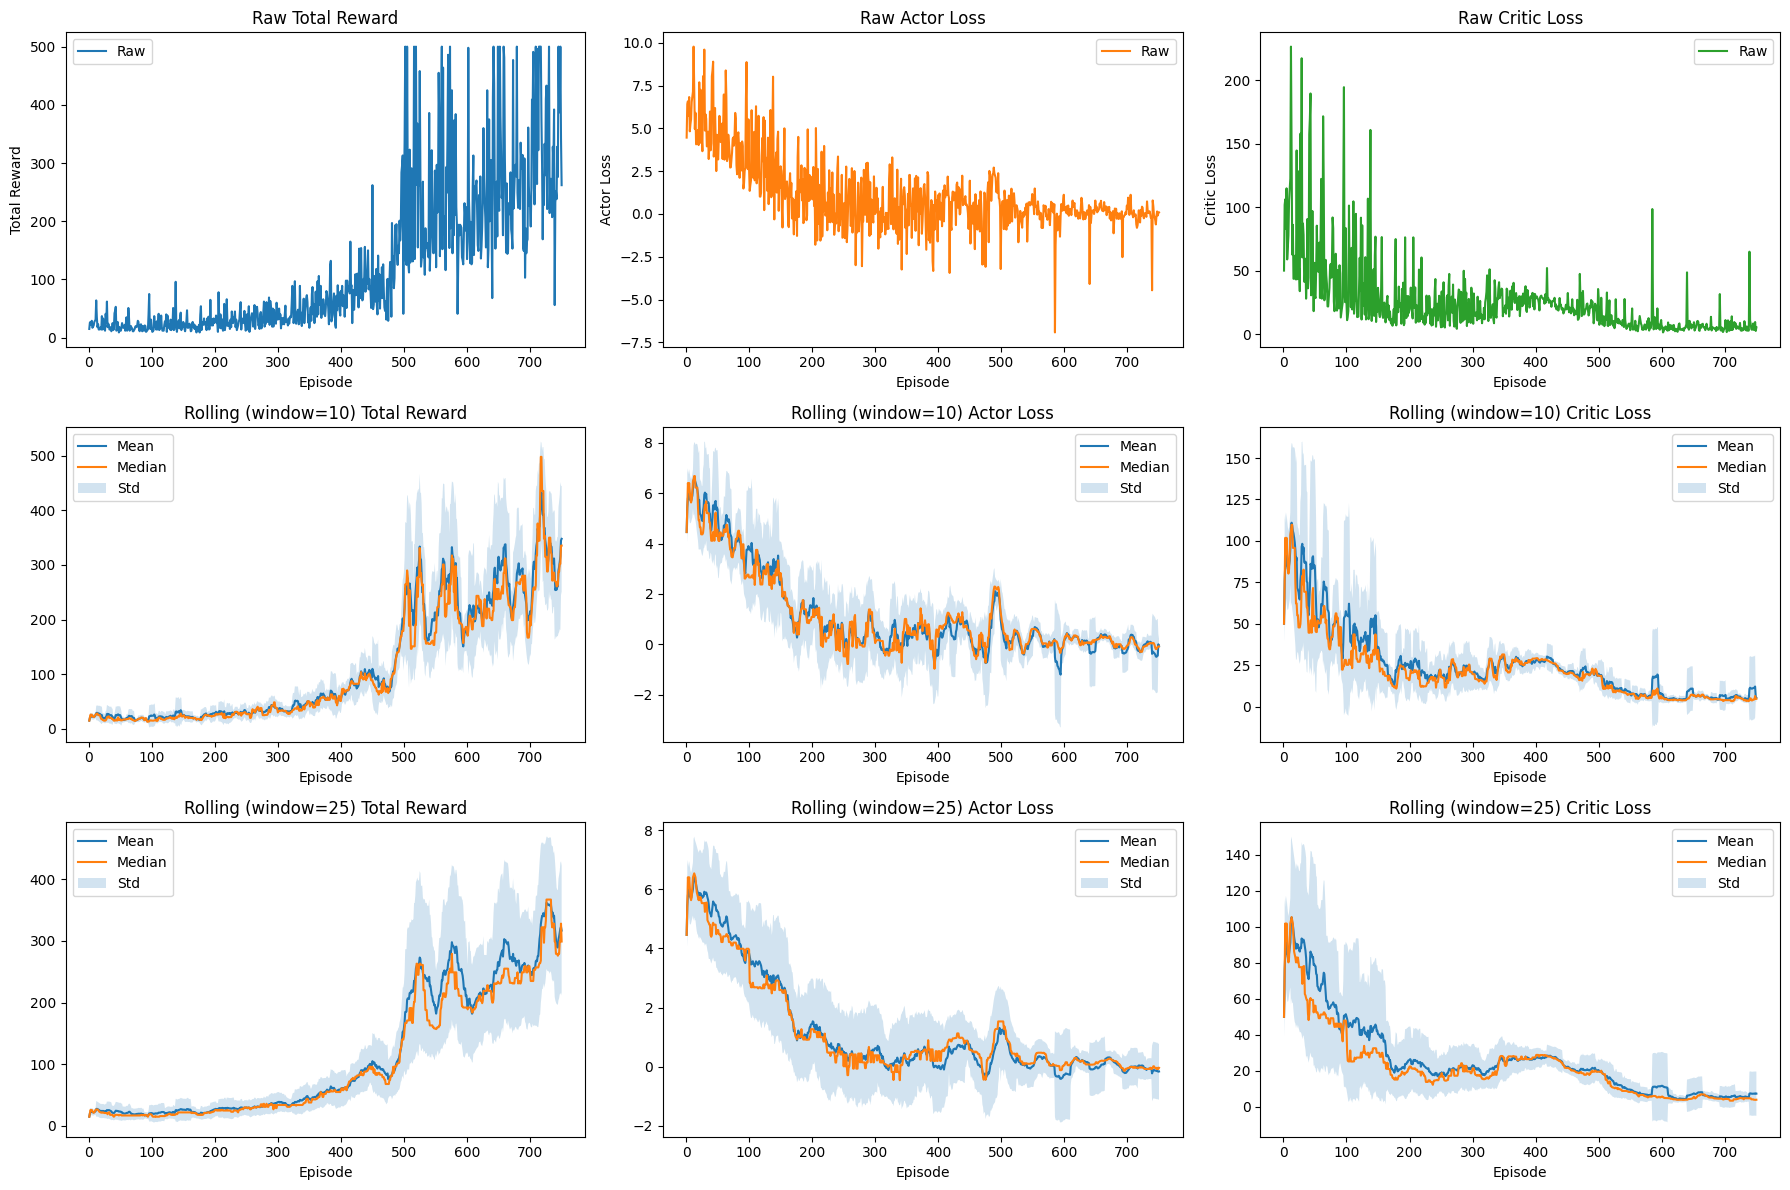

In [2]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 5e-3,
        "critic_lr": 5e-3,
        "num_episodes": 750,
        "gamma": 0.95,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

    plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)

Episode 10	Total Reward: 45.00	Actor Loss: 8.4234	Critic Loss: 173.7613
Episode 20	Total Reward: 24.00	Actor Loss: 5.7144	Critic Loss: 86.1716
Episode 30	Total Reward: 10.00	Actor Loss: 2.8011	Critic Loss: 21.0761
Episode 40	Total Reward: 12.00	Actor Loss: 2.7738	Critic Loss: 23.4797
Episode 50	Total Reward: 16.00	Actor Loss: 2.9744	Critic Loss: 31.8436
Episode 60	Total Reward: 9.00	Actor Loss: 0.3159	Critic Loss: 8.3262
Episode 70	Total Reward: 22.00	Actor Loss: 3.0177	Critic Loss: 33.9534
Episode 80	Total Reward: 33.00	Actor Loss: 3.8520	Critic Loss: 53.3677
Episode 90	Total Reward: 13.00	Actor Loss: -0.7756	Critic Loss: 14.9510
Episode 100	Total Reward: 31.00	Actor Loss: 2.1745	Critic Loss: 26.1491
Episode 110	Total Reward: 16.00	Actor Loss: -0.8517	Critic Loss: 7.4565
Episode 120	Total Reward: 24.00	Actor Loss: -0.1963	Critic Loss: 17.5975
Episode 130	Total Reward: 41.00	Actor Loss: 2.4005	Critic Loss: 37.8746
Episode 140	Total Reward: 19.00	Actor Loss: 0.5921	Critic Loss: 9.6391
E

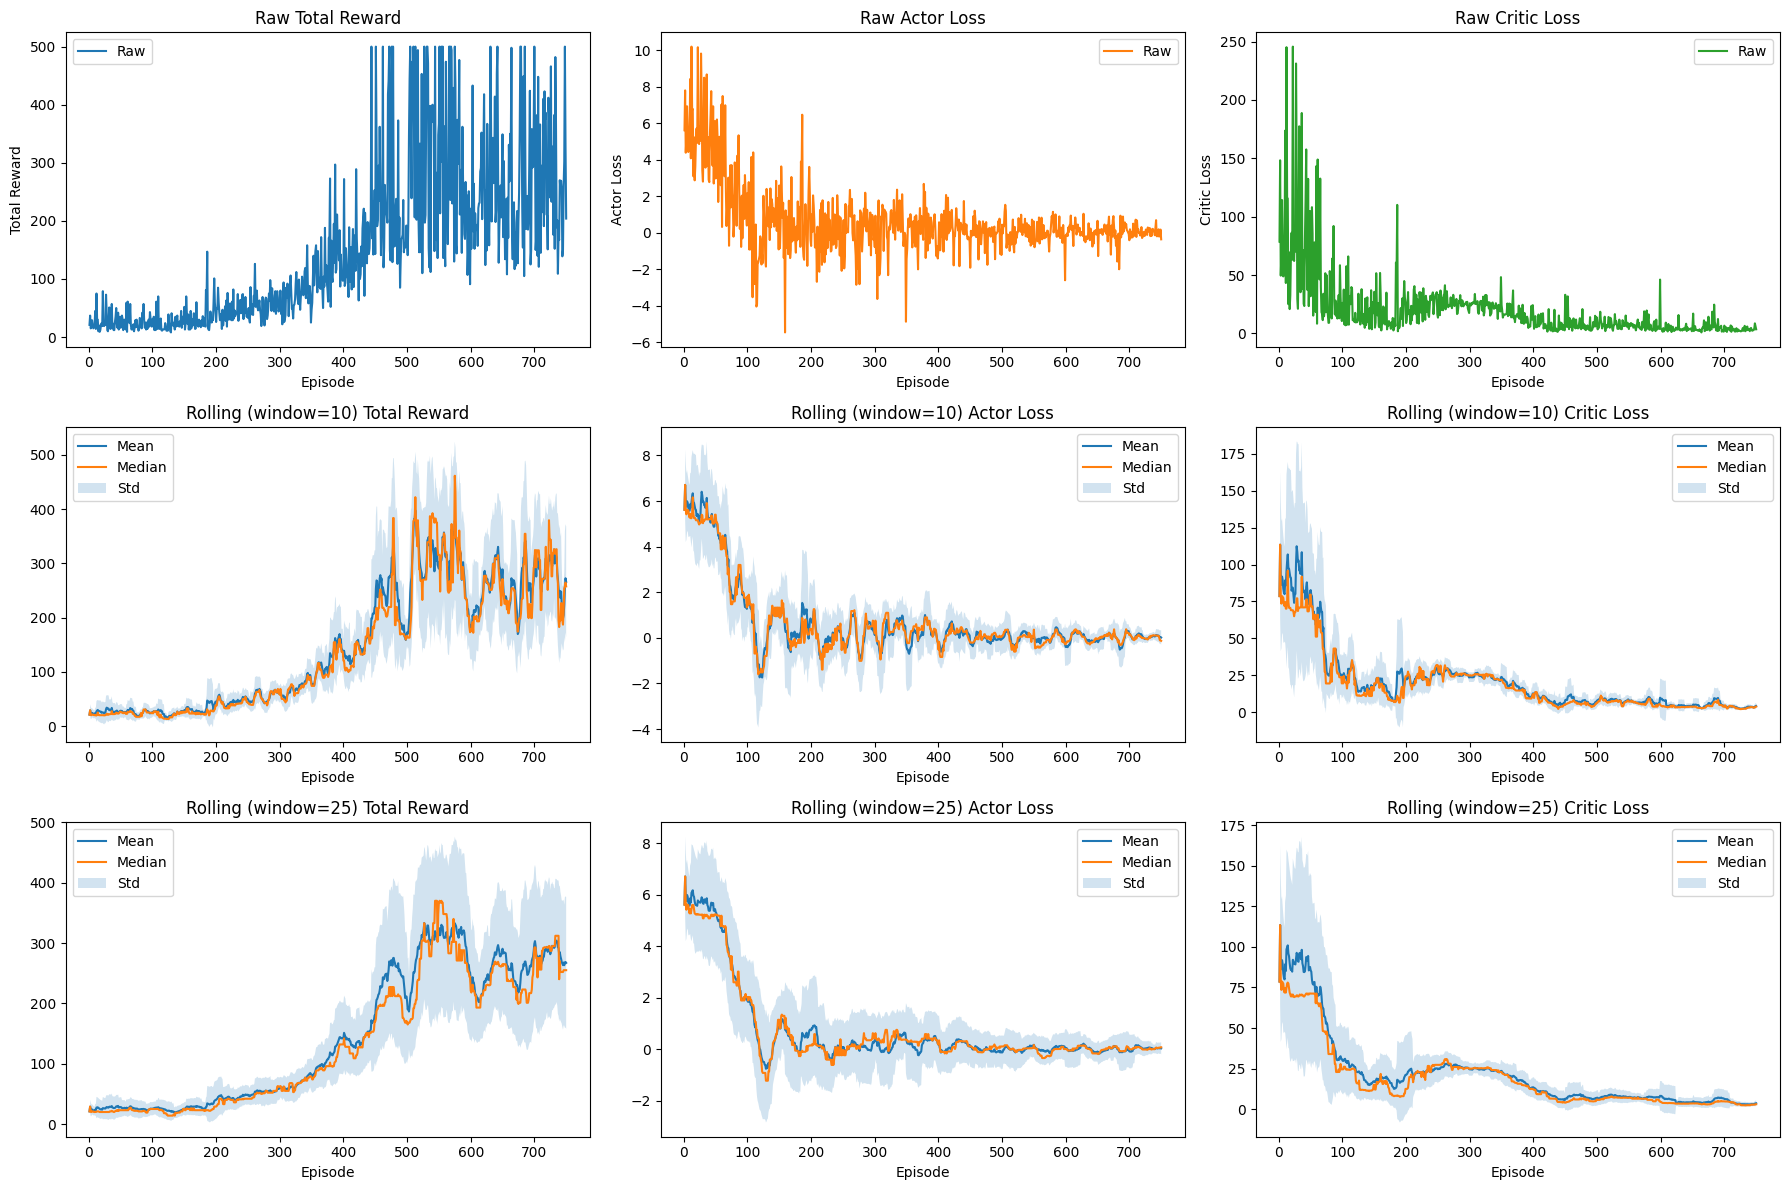

In [3]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 1e-2,
        "critic_lr": 1e-2,
        "num_episodes": 750,
        "gamma": 0.95,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

    plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)

2025-03-29 11:19:05.564199: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Episode 10	Total Reward: 26.00	Actor Loss: 5.0556	Critic Loss: 78.7260
Episode 20	Total Reward: 49.00	Actor Loss: 3.9021	Critic Loss: 72.6438
Episode 30	Total Reward: 32.00	Actor Loss: -0.5783	Critic Loss: 20.3874
Episode 40	Total Reward: 42.00	Actor Loss: -0.2972	Critic Loss: 24.5253
Episode 50	Total Reward: 30.00	Actor Loss: -1.1747	Critic Loss: 18.8206
Episode 60	Total Reward: 30.00	Actor Loss: -0.7042	Critic Loss: 15.0137
Episode 70	Total Reward: 64.00	Actor Loss: -0.8665	Critic Loss: 30.5642
Episode 80	Total Reward: 25.00	Actor Loss: -2.0145	Critic Loss: 16.2534
Episode 90	Total Reward: 61.00	Actor Loss: 1.5559	Critic Loss: 19.3221
Episode 100	Total Reward: 48.00	Actor Loss: -0.4329	Critic Loss: 26.9641
Episode 110	Total Reward: 77.00	Actor Loss: 1.2970	Critic Loss: 31.2396
Episode 120	Total Reward: 189.00	Actor Loss: 0.9961	Critic Loss: 16.3620
Episode 130	Total Reward: 138.00	Actor Loss: -0.0792	Critic Loss: 16.9987
Episode 140	Total Reward: 109.00	Actor Loss: 0.8923	Critic Loss

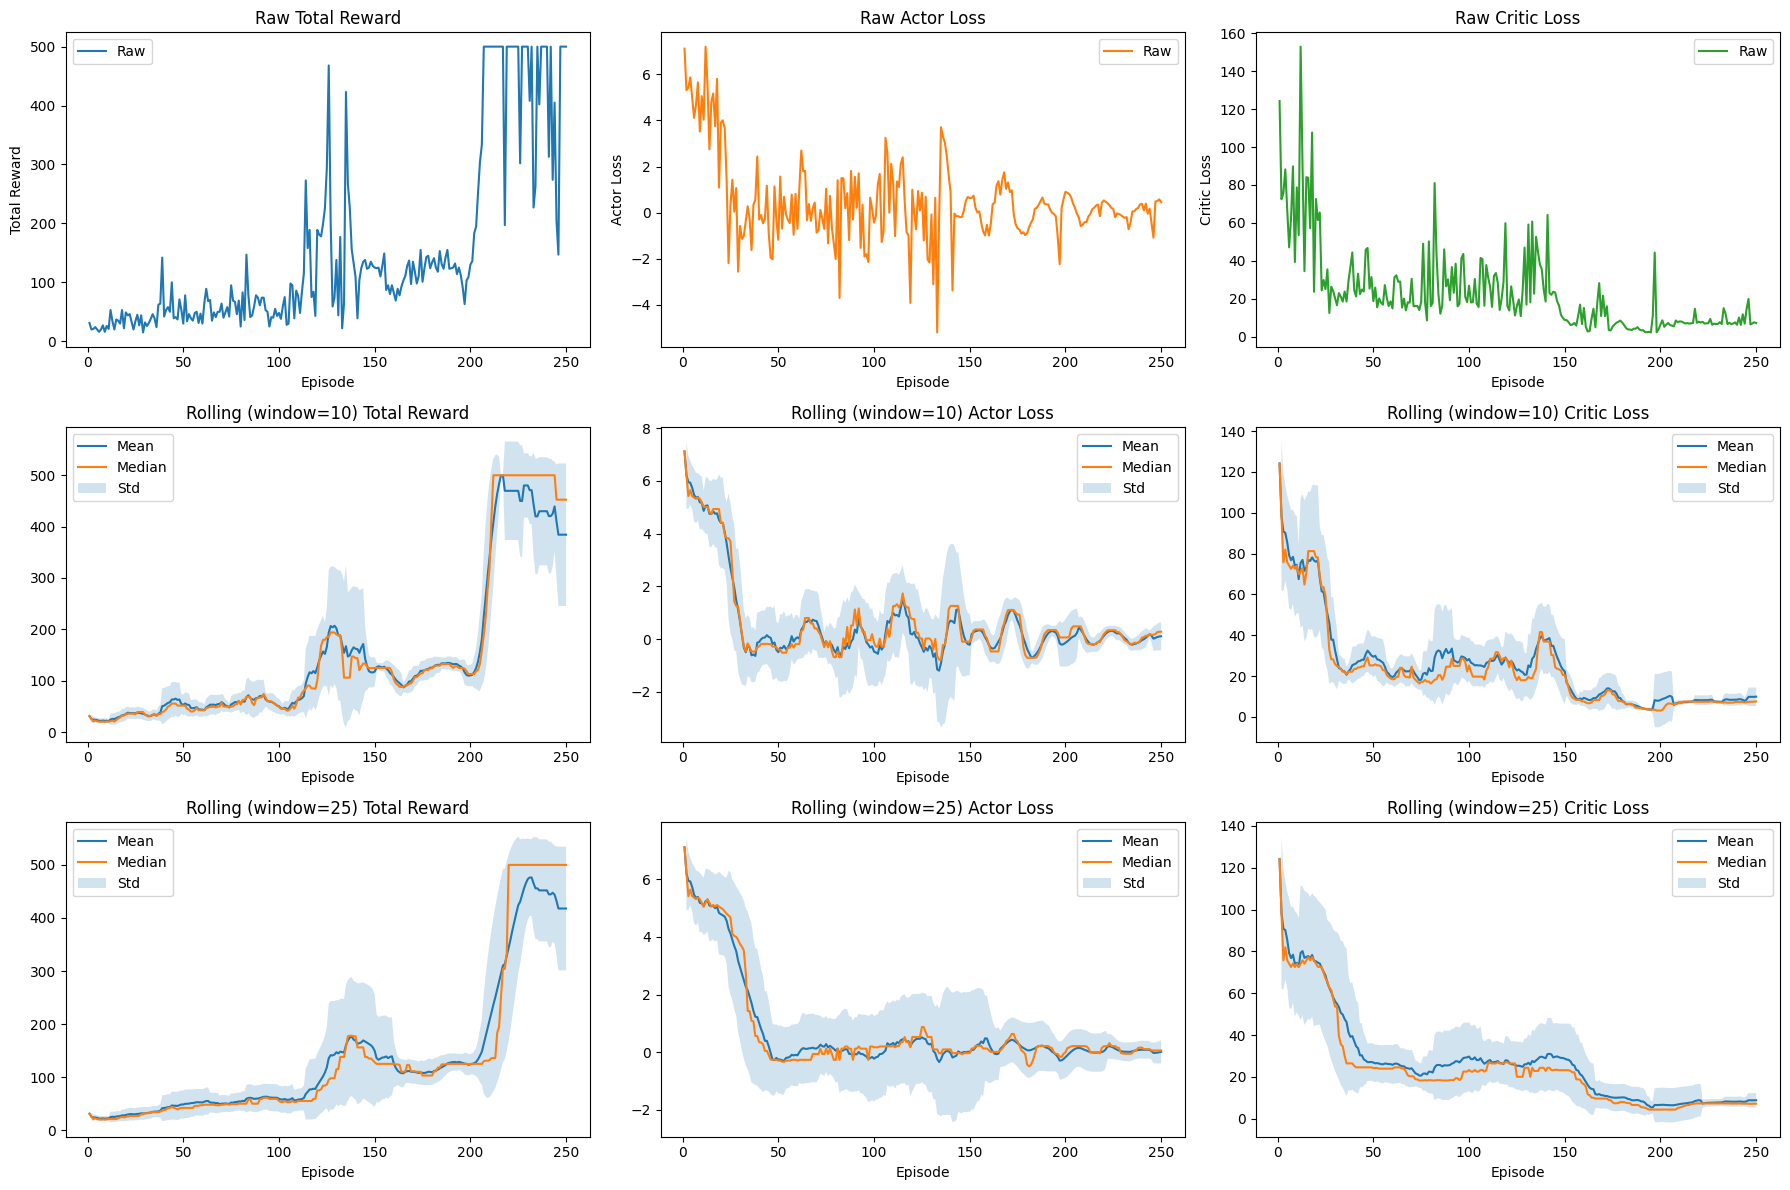

In [2]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 5e-2,
        "critic_lr": 5e-2,
        "num_episodes": 250,
        "gamma": 0.95,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

    plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)

Episode 10	Total Reward: 9.00	Actor Loss: 0.0175	Critic Loss: 8.1470
Episode 20	Total Reward: 10.00	Actor Loss: 0.0049	Critic Loss: 0.7690
Episode 30	Total Reward: 9.00	Actor Loss: 0.0103	Critic Loss: 1.0471
Episode 40	Total Reward: 9.00	Actor Loss: 0.0056	Critic Loss: 0.8279
Episode 50	Total Reward: 10.00	Actor Loss: 0.0077	Critic Loss: 0.4213
Episode 60	Total Reward: 9.00	Actor Loss: 0.0061	Critic Loss: 0.1971
Episode 70	Total Reward: 9.00	Actor Loss: -0.0043	Critic Loss: 0.3654
Episode 80	Total Reward: 9.00	Actor Loss: -0.1266	Critic Loss: 0.6593
Episode 90	Total Reward: 18.00	Actor Loss: -0.0111	Critic Loss: 10.7774
Episode 100	Total Reward: 58.00	Actor Loss: -0.5003	Critic Loss: 47.4263
Episode 110	Total Reward: 39.00	Actor Loss: -1.4098	Critic Loss: 45.3549
Episode 120	Total Reward: 42.00	Actor Loss: 0.0616	Critic Loss: 18.1613
Episode 130	Total Reward: 24.00	Actor Loss: 0.1301	Critic Loss: 8.3766
Episode 140	Total Reward: 31.00	Actor Loss: -0.0384	Critic Loss: 4.0089
Episode 150

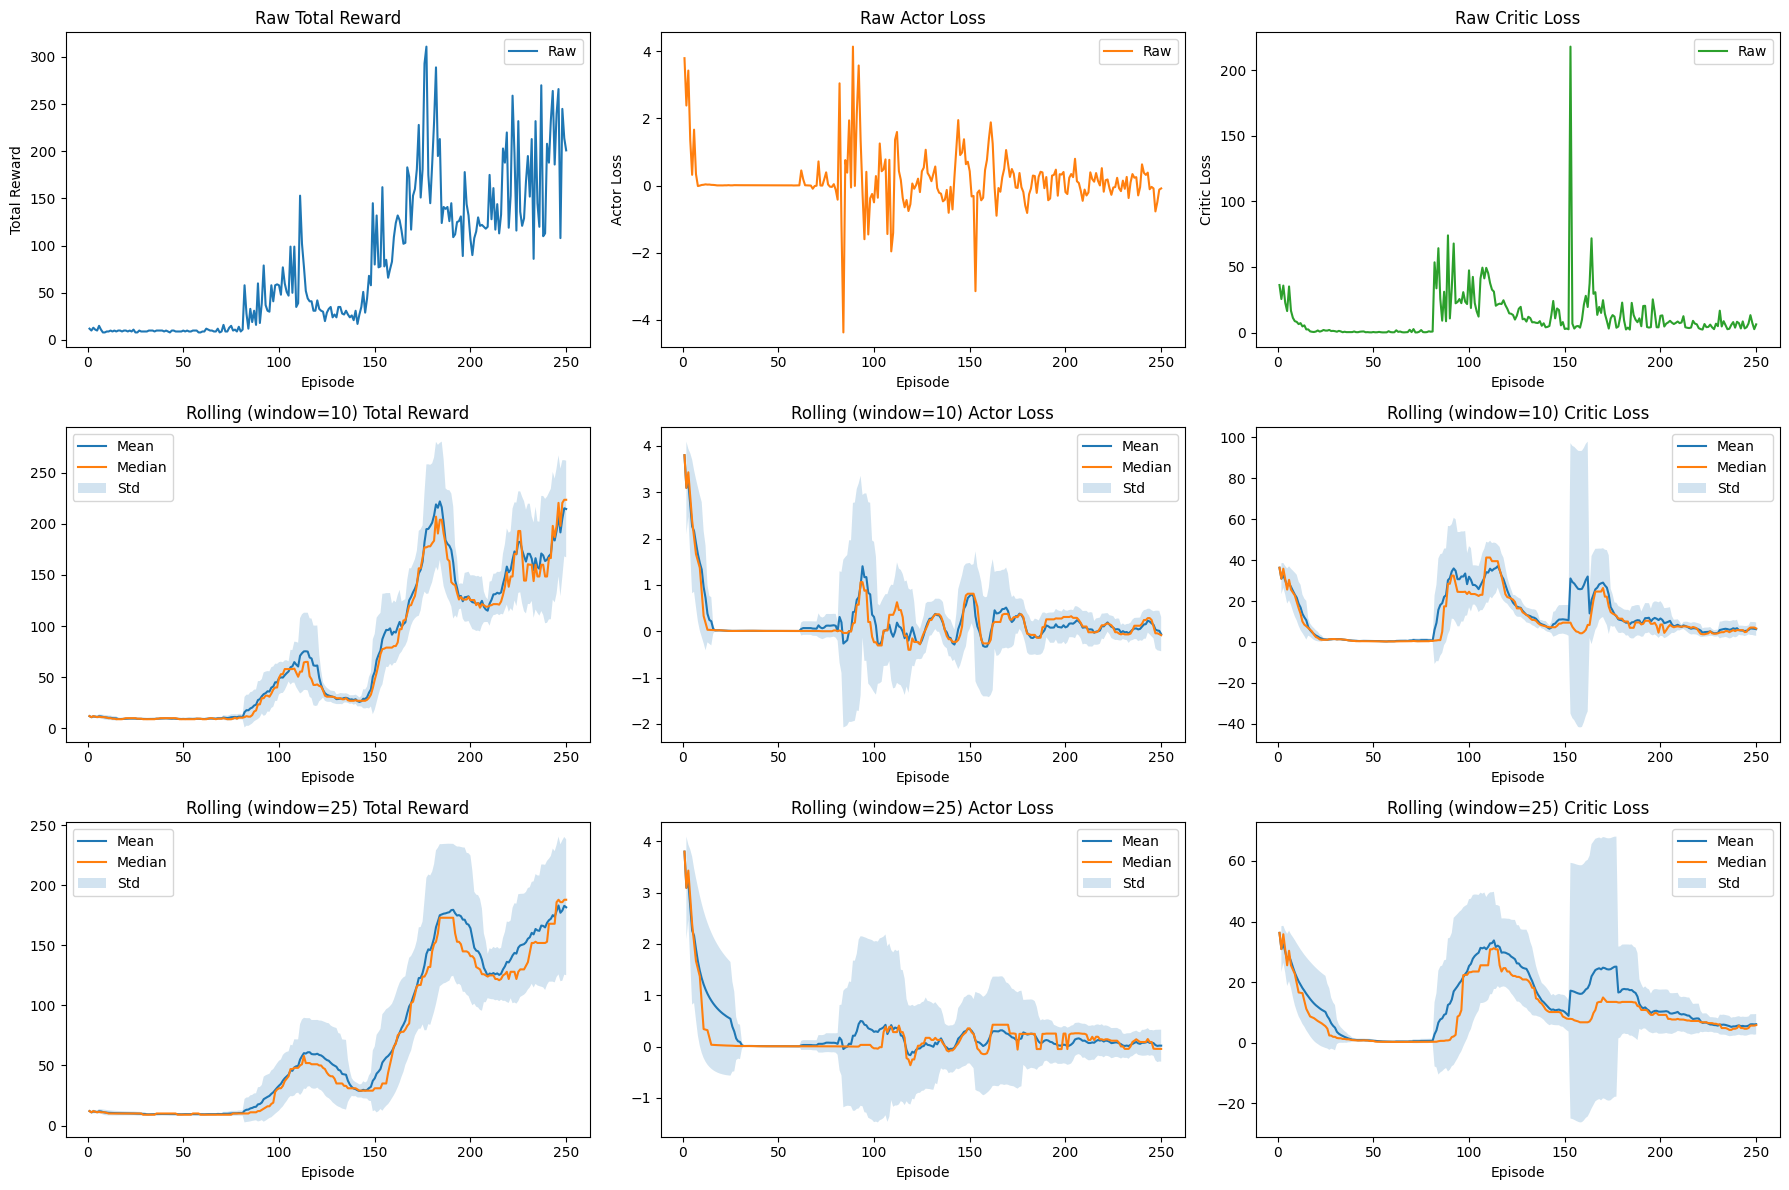

In [3]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 1e-1,
        "critic_lr": 1e-1,
        "num_episodes": 250,
        "gamma": 0.95,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

    plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)

Episode 10	Total Reward: 9.00	Actor Loss: 0.0821	Critic Loss: 2.3440
Episode 20	Total Reward: 9.00	Actor Loss: 0.0536	Critic Loss: 0.6999
Episode 30	Total Reward: 8.00	Actor Loss: 0.0302	Critic Loss: 1.9313
Episode 40	Total Reward: 9.00	Actor Loss: 0.0131	Critic Loss: 0.6807
Episode 50	Total Reward: 9.00	Actor Loss: 0.0066	Critic Loss: 0.4652
Episode 60	Total Reward: 9.00	Actor Loss: 0.0021	Critic Loss: 0.5518
Episode 70	Total Reward: 8.00	Actor Loss: 0.0012	Critic Loss: 0.2772
Episode 80	Total Reward: 10.00	Actor Loss: -0.0006	Critic Loss: 1.6671
Episode 90	Total Reward: 9.00	Actor Loss: 0.0225	Critic Loss: 1.1475
Episode 100	Total Reward: 9.00	Actor Loss: 0.0203	Critic Loss: 0.2414
Episode 110	Total Reward: 9.00	Actor Loss: 0.0192	Critic Loss: 0.2060
Episode 120	Total Reward: 10.00	Actor Loss: 0.0108	Critic Loss: 1.4468
Episode 130	Total Reward: 8.00	Actor Loss: 0.0054	Critic Loss: 2.9076
Episode 140	Total Reward: 10.00	Actor Loss: 0.0035	Critic Loss: 0.2026
Episode 150	Total Reward:

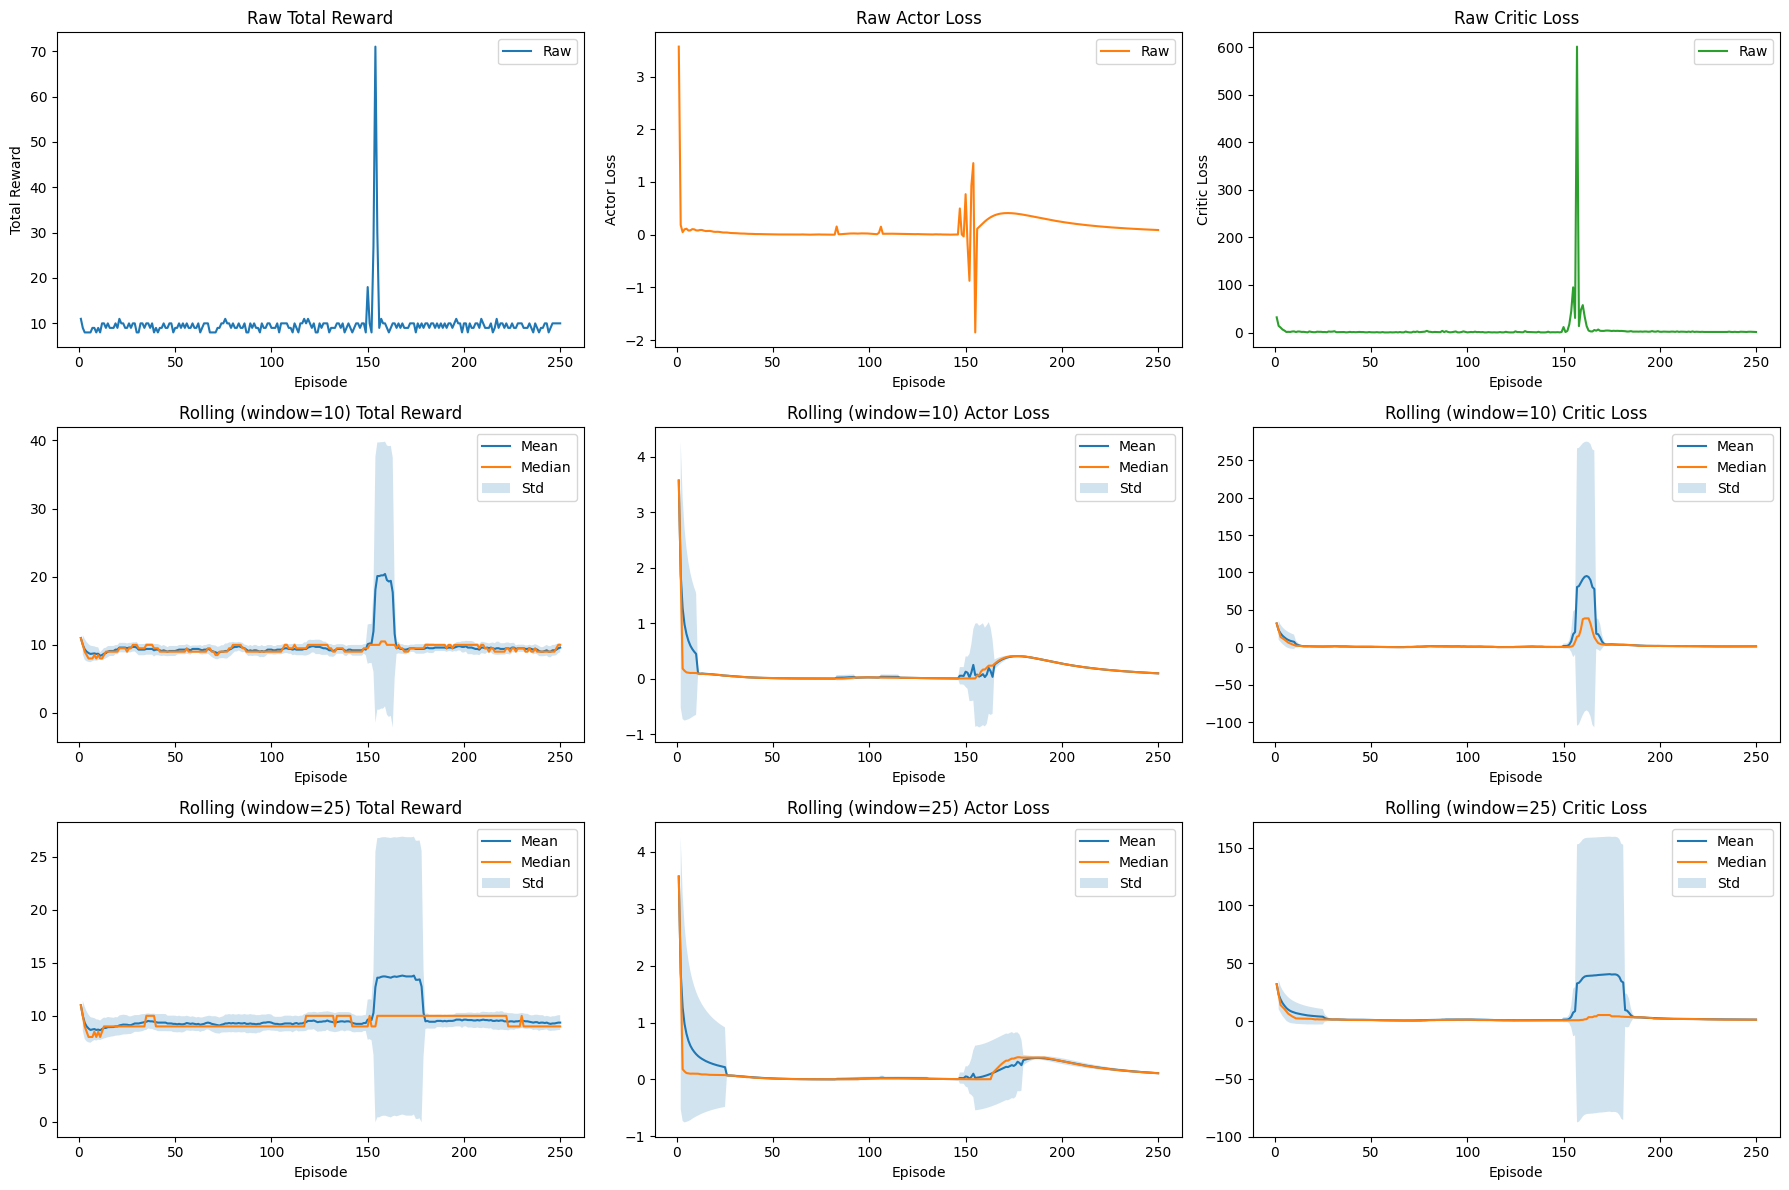

In [4]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 5e-1,
        "critic_lr": 5e-1,
        "num_episodes": 250,
        "gamma": 0.95,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

    plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)

Episode 10	Total Reward: 13.00	Actor Loss: 2.6271	Critic Loss: 38.6013
Episode 20	Total Reward: 9.00	Actor Loss: -1.0655	Critic Loss: 23.7335
Episode 30	Total Reward: 22.00	Actor Loss: 2.4554	Critic Loss: 51.5960
Episode 40	Total Reward: 47.00	Actor Loss: 4.2838	Critic Loss: 155.1607
Episode 50	Total Reward: 37.00	Actor Loss: -0.2237	Critic Loss: 55.9857
Episode 60	Total Reward: 27.00	Actor Loss: 1.1088	Critic Loss: 26.5099
Episode 70	Total Reward: 26.00	Actor Loss: 0.6574	Critic Loss: 18.0203
Episode 80	Total Reward: 39.00	Actor Loss: -0.7634	Critic Loss: 34.7078
Episode 90	Total Reward: 24.00	Actor Loss: -2.3220	Critic Loss: 40.2229
Episode 100	Total Reward: 49.00	Actor Loss: -5.2061	Critic Loss: 447.6684
Episode 110	Total Reward: 59.00	Actor Loss: 3.3926	Critic Loss: 157.5097
Episode 120	Total Reward: 72.00	Actor Loss: 2.1197	Critic Loss: 247.9050
Episode 130	Total Reward: 104.00	Actor Loss: 2.7575	Critic Loss: 401.3764
Episode 140	Total Reward: 83.00	Actor Loss: 2.1279	Critic Loss:

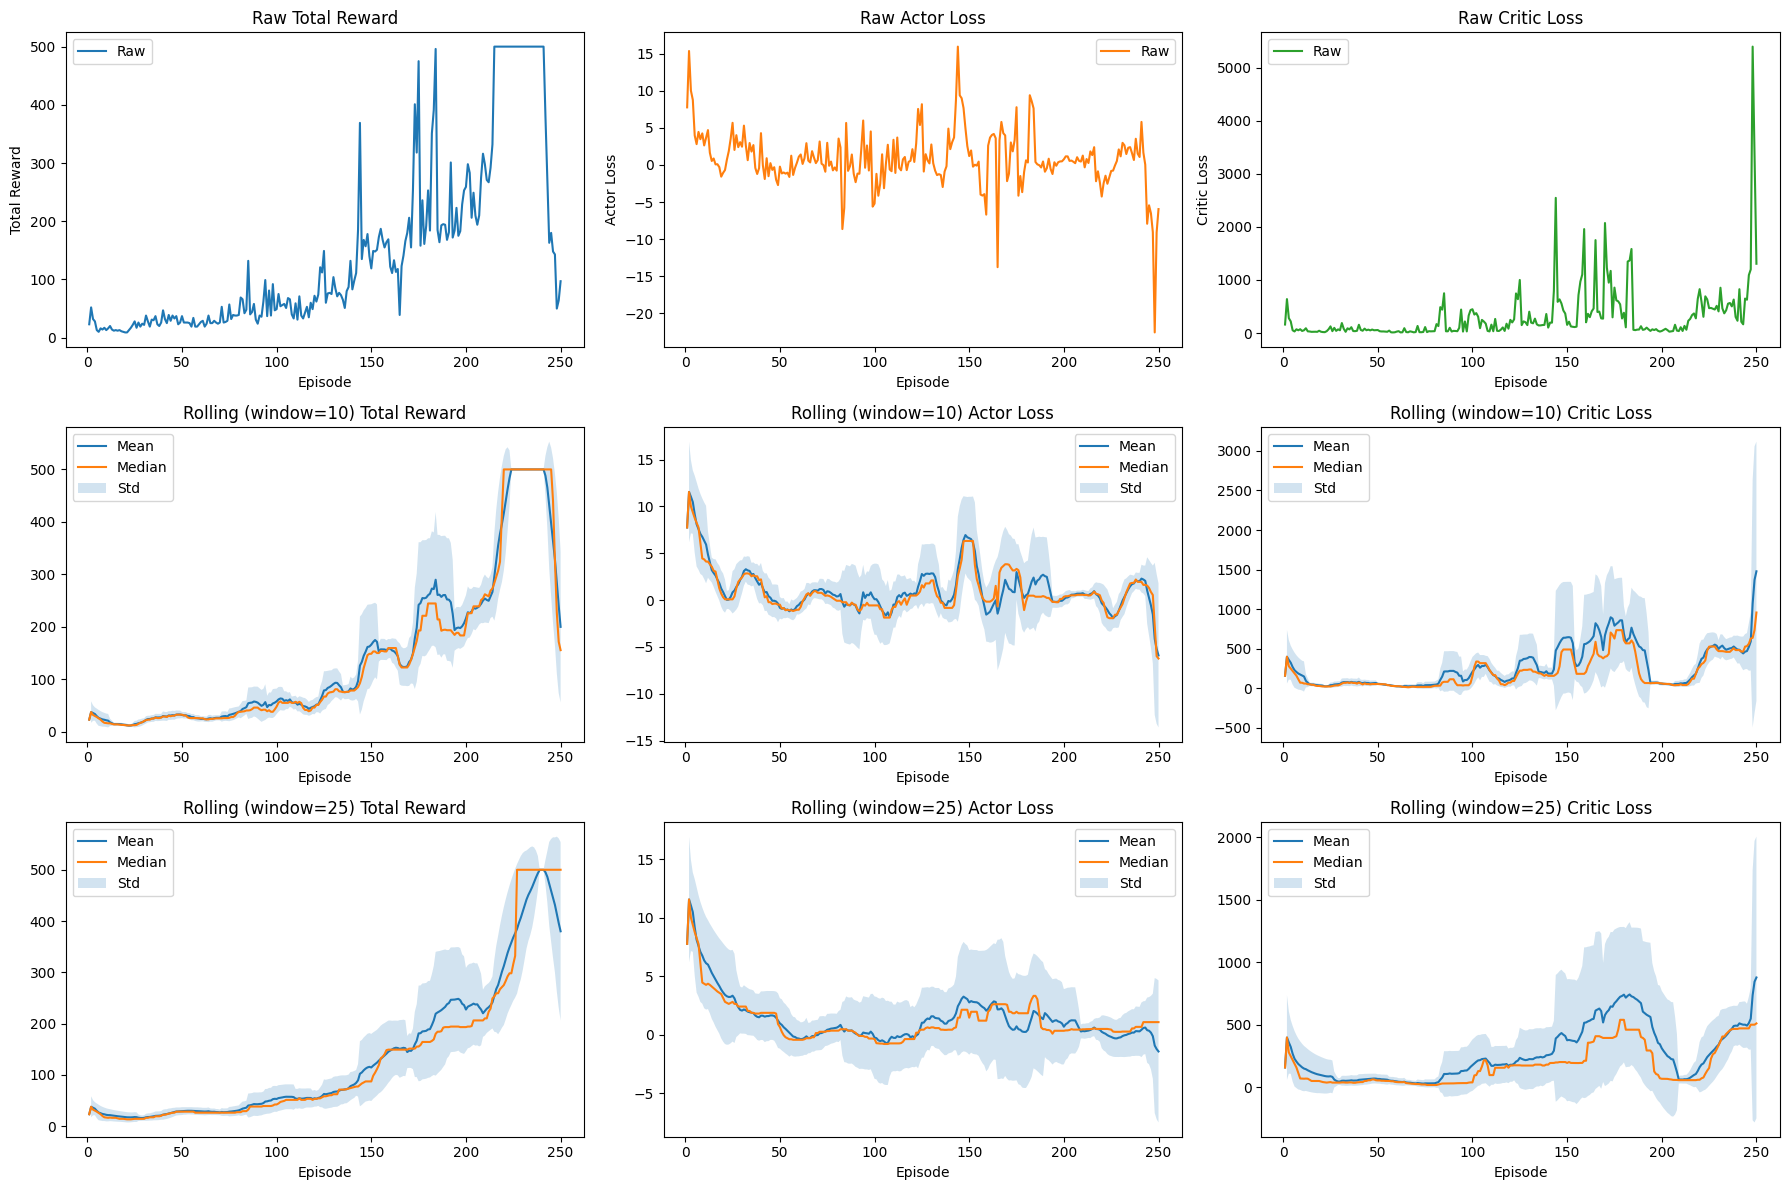

In [5]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 5e-2,
        "critic_lr": 5e-2,
        "num_episodes": 250,
        "gamma": 0.99,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

    plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)

Episode 10	Total Reward: 9.00	Actor Loss: 0.3842	Critic Loss: 8.7749
Episode 20	Total Reward: 12.00	Actor Loss: 0.5104	Critic Loss: 5.1253
Episode 30	Total Reward: 12.00	Actor Loss: 0.0613	Critic Loss: 1.1887
Episode 40	Total Reward: 15.00	Actor Loss: 0.5563	Critic Loss: 1.6557
Episode 50	Total Reward: 11.00	Actor Loss: -0.0211	Critic Loss: 0.5936
Episode 60	Total Reward: 10.00	Actor Loss: -0.0603	Critic Loss: 0.1905
Episode 70	Total Reward: 8.00	Actor Loss: -0.2192	Critic Loss: 0.5668
Episode 80	Total Reward: 9.00	Actor Loss: -0.1602	Critic Loss: 0.4049
Episode 90	Total Reward: 17.00	Actor Loss: 0.0547	Critic Loss: 0.9430
Episode 100	Total Reward: 17.00	Actor Loss: -0.1572	Critic Loss: 0.5179
Episode 110	Total Reward: 9.00	Actor Loss: 0.0080	Critic Loss: 0.8281
Episode 120	Total Reward: 14.00	Actor Loss: 0.2021	Critic Loss: 0.8720
Episode 130	Total Reward: 15.00	Actor Loss: 0.0584	Critic Loss: 0.4046
Episode 140	Total Reward: 10.00	Actor Loss: -0.2117	Critic Loss: 0.4891
Episode 150	T

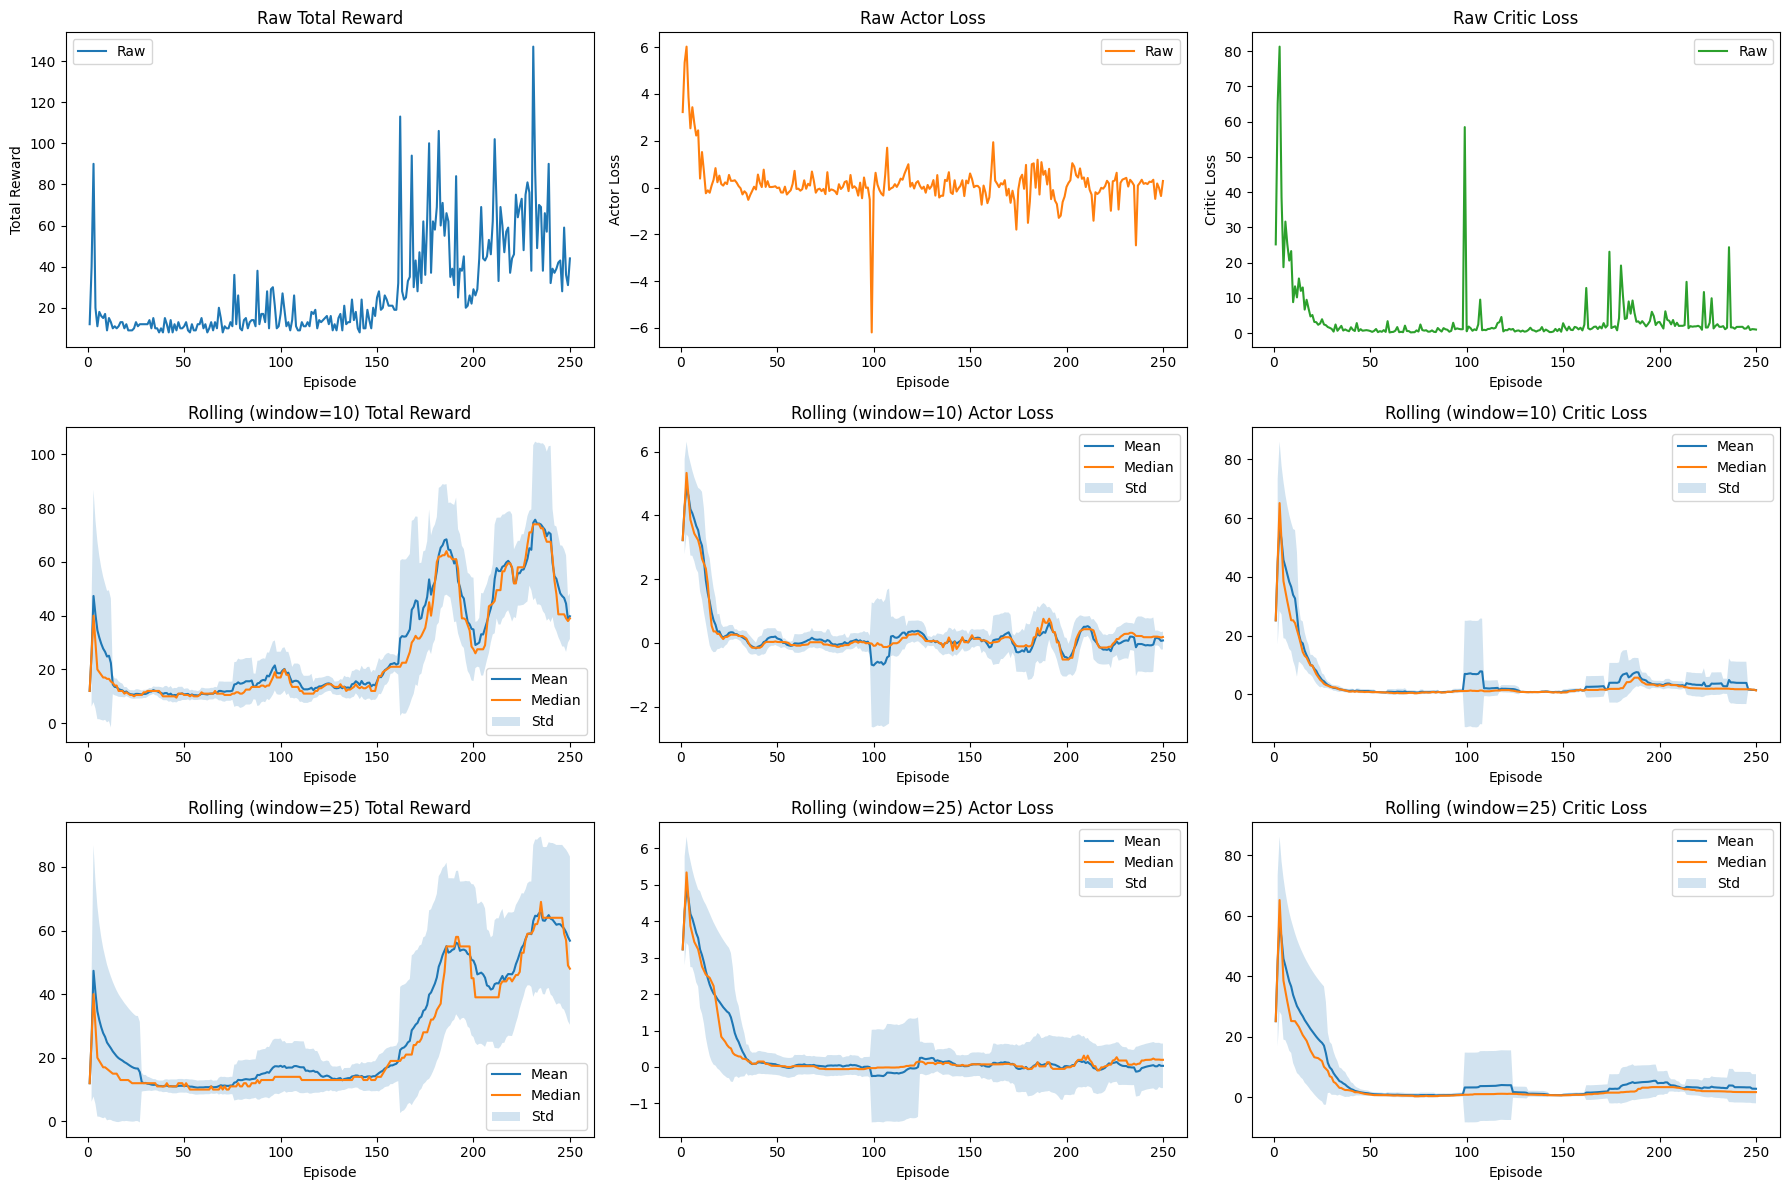

In [6]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 5e-2,
        "critic_lr": 5e-2,
        "num_episodes": 250,
        "gamma": 0.90,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

    plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)